# Proyecto C

Estudiantes: 

1. Mariana Lozano Roncancio 202122878

# A. Presentaccion de modelo 

A continuacion se presenta el modlo con las siguientes cambios realizados:

- Adición de restricciones de continuidad y consumo de combustible.
- Inclusión de variables auxiliares para orden y combustible restante.
- Restricciones MTZ para evitar subtours.
- Inclusión de la restricción de visita única a cada cliente.
- Reorganización del modelo para mejorar su claridad y consistencia.

## 1. Conjuntos

- **P**: Conjunto de puntos de acceso (puertos)
- **D**: Conjunto de destinos (centros de consumo)
- **E**: Conjunto de estaciones de recarga
- **V**: Conjunto de vehículos
- **N**: Conjunto total de nodos, `N = P ∪ D ∪ E`
- **A**: Conjunto de arcos posibles, `A = {(i, j) ∈ N × N | i ≠ j}`

# 2. Parámetros
- `d_ij`: Distancia entre nodos i y j
- `C_ij`: Costo base entre nodos i y j
- `M_v`: Capacidad útil del vehículo v
- `A_v`: Autonomía del vehículo v
- `R_v`: Rendimiento (km/gal) del vehículo v
- `L_j`: Límite de peso en el nodo j
- `P_s`: Precio de galón en estación s
- `F_t`: Tarifa de flete (COP/km)
- `C_m`: Costo de mantenimiento (COP/km)
- `E_v`: Penalización por CO₂ por km para el vehículo v
- `T_ij`: Peaje base en tramo i → j
- `T2_ij`: Peaje adicional por tonelada
- `demand_j`: Demanda en el nodo j


## 3. Variables de decisión
- `x_ijv ∈ {0,1}`: 1 si el vehículo v viaja de i a j
- `q_ijv ≥ 0`: Carga transportada entre i y j por v
- `z_ijv ≥ 0`: Variable auxiliar para `q * x`
- `f_ijv ≥ 0`: Combustible consumido entre i y j
- `r_sv ≥ 0`: Galones recargados en la estación s por v
- `y_sv ∈ {0,1}`: 1 si v recarga en estación s
- `u_iv ≥ 0`: Orden de visita del nodo i por v
- `comb_iv ≥ 0`: Combustible restante en i por v

## 4. Función Objetivo

Minimizar el costo total de operación:

$$
\min \sum_v \sum_{(i,j)} \left( 
C_{ij} \cdot x_{ijv} + 
F_t \cdot d_{ij} \cdot x_{ijv} + 
C_m \cdot d_{ij} \cdot x_{ijv} + 
T_{ij} \cdot x_{ijv} + 
T2_{ij} \cdot z_{ijv} + 
E_v \cdot d_{ij} \cdot x_{ijv} 
\right) + \sum_v \sum_s P_s \cdot r_{sv}
$$


##  Restricciones

### 1. Conservación de flujo

$$
\sum_{j \in N, j \ne n} x_{jnv} = \sum_{j \in N, j \ne n} x_{njv}
\quad \forall n \in N, \forall v \in V
$$



### 2. Capacidad del vehículo

$$
q_{ijv} \le M_v \cdot x_{ijv}
\quad \forall (i,j) \in A, \forall v \in V
$$



### 3. Límite de peso por municipio

$$
q_{ijv} \le L_j
\quad \forall (i,j) \in A, j \in D, \forall v \in V
$$



### 4. Consumo de combustible

$$
f_{ijv} = \frac{d_{ij}}{R_v} \cdot x_{ijv}
\quad \forall (i,j) \in A, \forall v \in V
$$



### 5. Continuidad del combustible

$$
comb_{jv} = comb_{iv} - f_{ijv} + r_{jv}
\quad \forall (i,j) \in A, \forall v \in V
$$



### 6. Recarga en estación activa

$$
r_{sv} \le M \cdot y_{sv}
\quad \forall s \in E, \forall v \in V
$$



### 7. Eliminación de subtours (MTZ)

$$
u_{iv} - u_{jv} + |D| \cdot x_{ijv} \le |D| - 1
\quad \forall i \ne j \in D, \forall v \in V
$$



### 8. Satisfacción de la demanda

$$
\sum_{i \in N, i \ne j} \sum_{v \in V} q_{ijv} \ge demand_j
\quad \forall j \in D
$$



### 9. Linealización de \( z = q \cdot x \)

$$
\begin{aligned}
z_{ijv} &\le q_{ijv} \\
z_{ijv} &\le M_v \cdot x_{ijv} \\
z_{ijv} &\ge q_{ijv} - M_v \cdot (1 - x_{ijv})
\end{aligned}
$$

# B. Presentacion de Notebook ejecutado

In [3]:
!apt-get install -y coinor-cbc
!pip install pyomo


"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Datos cargados correctamente.
Vehículos: 5
Estaciones: 12
Depósitos: 1
Clientes: 14
Reduciendo número de clientes para mejorar rendimiento...
Reduciendo número de estaciones para mejorar rendimiento...
Modelo utilizará: 5 vehículos, 8 estaciones, 1 depósitos, 10 clientes
Parámetros inicializados correctamente.
Variables definidas correctamente.
Función objetivo definida correctamente.
Restricciones definidas correctamente.
Tiempo transcurrido: 0.03 segundos. Tiempo restante: 1199.97 segundos.
Usando solucionador GLPK
Iniciando resolución con tiempo límite de 600 segundos...
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.15 --tmlim 600 --write C:\Users\MARIAN~1\AppData\Local\Temp\tmprftzbux_.glpk.raw
 --wglp C:\Users\MARIAN~1\AppData\Local\Temp\tmp5hd54lqn.glpk.glp --cpxlp
 C:\Users\MARIAN~1\AppData\Local\Temp\tmputjs9lk6.pyomo.lp
Reading problem data from 'C:\Users\MARIAN~1\AppData\Local\Temp\tmputjs9lk6.pyomo.lp'...
C:\Users\MARIAN~1\AppData\

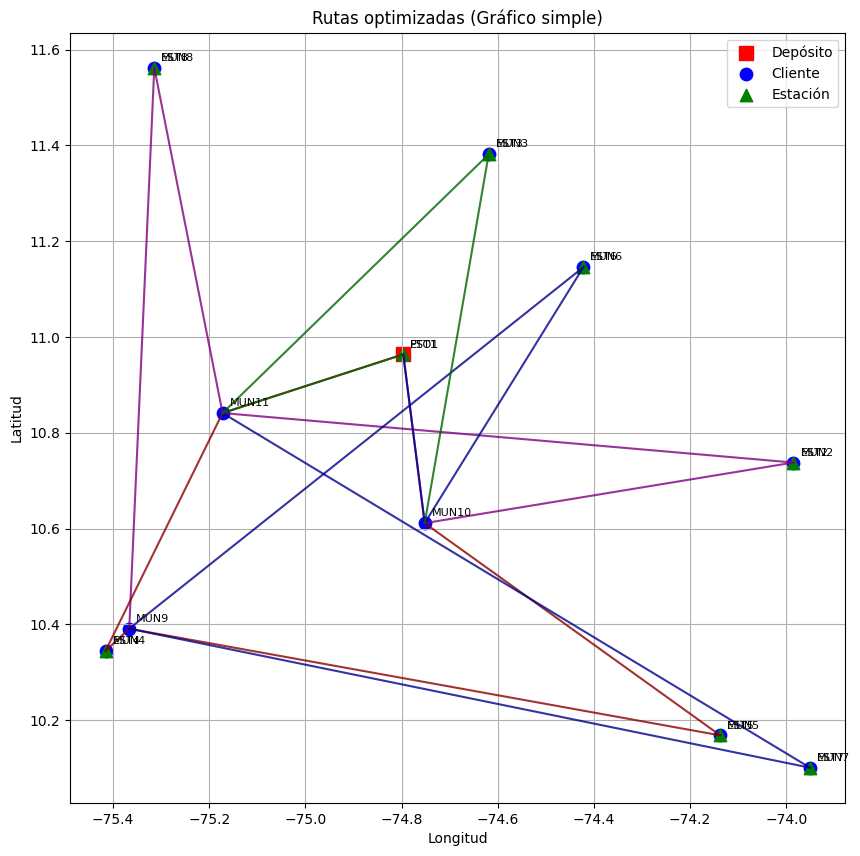

Mapa simple mostrado correctamente.
No se encontró solución óptima.
Estado: ok
Condición: feasible


In [10]:
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import folium
import numpy as np
import csv
import time
from math import radians, sin, cos, sqrt, atan2

# Establecer un tiempo límite para todo el proceso
tiempo_limite_total = 1200  # 20 minutos en segundos
tiempo_inicio = time.time()

# Cargar archivos
try:
    vehicles = pd.read_csv("datos/vehicles2.csv")
    stations = pd.read_csv("datos/stations2.csv")
    depots = pd.read_csv("datos/depots2.csv")
    clients = pd.read_csv("datos/clients2.csv")

    print("Datos cargados correctamente.")
    print(f"Vehículos: {len(vehicles)}")
    print(f"Estaciones: {len(stations)}")
    print(f"Depósitos: {len(depots)}")
    print(f"Clientes: {len(clients)}")
except Exception as e:
    print(f"Error al cargar datos: {e}")
    raise

# Conjuntos
V = list(vehicles["VehicleID"].astype(str))
E = list(stations["EstationID"].astype(str))
P = list(depots["DepotID"].astype(str))
D = list(clients["LocationID"].astype(str))

# Reducir el tamaño del problema si es demasiado grande
if len(V) > 5:
    print("Reduciendo número de vehículos para mejorar rendimiento...")
    V = V[:5]  # Usar solo los primeros 5 vehículos

if len(D) > 10:
    print("Reduciendo número de clientes para mejorar rendimiento...")
    D = D[:10]  # Usar solo los primeros 10 clientes

if len(E) > 8:
    print("Reduciendo número de estaciones para mejorar rendimiento...")
    E = E[:8]  # Usar solo las primeras 8 estaciones

# Aseguramos que todos los IDs sean strings
V = [str(v) for v in V]
E = [str(e) for e in E]
P = [str(p) for p in P]
D = [str(d) for d in D]

print(f"Modelo utilizará: {len(V)} vehículos, {len(E)} estaciones, {len(P)} depósitos, {len(D)} clientes")

# Filtrar clientes para incluir solo los que están en D
clients = clients[clients["LocationID"].astype(str).isin(D)]

N = P + D + E  # Ahora incluimos las estaciones E en los nodos
A = [(i, j) for i in N for j in N if i != j]

# Parámetros
M_v = dict(zip(V, vehicles.loc[vehicles["VehicleID"].astype(str).isin(V), "Capacity"]))
A_v = dict(zip(V, vehicles.loc[vehicles["VehicleID"].astype(str).isin(V), "Range"]))

# Verificar si existe la columna FuelConsumption
if "FuelConsumption" in vehicles.columns:
    R_v = dict(zip(V, vehicles.loc[vehicles["VehicleID"].astype(str).isin(V), "FuelConsumption"]))
else:
    # Valor estimado de consumo basado en autonomía
    R_v = {v: A_v[v]/400 for v in V}  # Km por galón (valor estimado)

# Límites de peso por cliente - asumimos que no hay restricciones especiales
L_j = {j: 99999 for j in D}  # Límites de peso alto por defecto

# Demanda por cliente
demand = dict(zip(clients["LocationID"].astype(str), clients["Demand"]))

# Precio de combustible en cada estación
P_s = dict(zip(stations.loc[stations["EstationID"].astype(str).isin(E), "EstationID"].astype(str), 
               stations.loc[stations["EstationID"].astype(str).isin(E), "FuelCost"]))

# Coordenadas para calcular distancias
coords = {}

# Añadir coordenadas de depósitos
for _, row in depots.iterrows():
    coords[str(row["DepotID"])] = (row["Latitude"], row["Longitude"])

# Añadir coordenadas de estaciones
for _, row in stations.loc[stations["EstationID"].astype(str).isin(E)].iterrows():
    coords[str(row["EstationID"])] = (row["Latitude"], row["Longitude"])

# Para los clientes, necesitamos asignarles coordenadas apropiadas
# Opción: Generar coordenadas sintéticas que estén cerca de los depósitos
# para crear un problema espacialmente coherente
np.random.seed(42)  # Para reproducibilidad

# Encontrar el centro aproximado de los depósitos
if coords:
    avg_lat = np.mean([coords[p][0] for p in P])
    avg_lon = np.mean([coords[p][1] for p in P])
else:
    # Si no hay datos de coordenadas disponibles, usar un punto arbitrario en Colombia
    avg_lat = 4.710989
    avg_lon = -74.072092

# Generar coordenadas para clientes dentro de un radio razonable del centro
for client_id in D:
    # Radio máximo en grados (aproximadamente 100 km)
    max_radius = 0.9
    # Generar offset aleatorio pero limitado
    offset_lat = np.random.uniform(-max_radius, max_radius)
    offset_lon = np.random.uniform(-max_radius, max_radius)
    
    # Asignar coordenadas
    coords[client_id] = (avg_lat + offset_lat, avg_lon + offset_lon)

# Función para calcular distancia haversine
def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371.0
    
    # Convertir coordenadas a radianes
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Diferencias
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Fórmula haversine
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    # Factor de ajuste para vías colombianas (1.3x)
    return distance * 1.3

# Calcular distancias entre nodos
dist = {}
for i in N:
    for j in N:
        if i != j:
            if i in coords and j in coords:
                dist[(i, j)] = haversine(coords[i][0], coords[i][1], coords[j][0], coords[j][1])
            else:
                # Valor por defecto si faltan coordenadas (20 km)
                dist[(i, j)] = 20.0

# Definir costos
F_t = 50  # Ajustado: Costo de combustible por km
C_m = 10  # Ajustado: Costo de mantenimiento por km
C_ij = {(i, j): 100 for (i, j) in A}  # Ajustado: Costo fijo de usar arco
T_ij = {(i, j): 200 for (i, j) in A}  # Ajustado: Costo de tiempo
T2_ij = {(i, j): 5 for (i, j) in A}   # Ajustado: Costo por unidad de carga
E_v = {v: 5 for v in V}  # Ajustado: Costo de emisiones

print("Parámetros inicializados correctamente.")

# Crear modelo optimizado
model = pyo.ConcreteModel()

# Definir conjuntos
model.V = pyo.Set(initialize=V)
model.N = pyo.Set(initialize=N)
model.A = pyo.Set(initialize=A, dimen=2)
model.E = pyo.Set(initialize=E)
model.D = pyo.Set(initialize=D)
model.P = pyo.Set(initialize=P)

# Variables de decisión
model.x = pyo.Var(model.A, model.V, domain=pyo.Binary)  # 1 si vehículo v usa arco (i,j)
model.q = pyo.Var(model.A, model.V, domain=pyo.NonNegativeReals)  # Carga transportada
model.y = pyo.Var(model.E, model.V, domain=pyo.Binary)  # 1 si vehículo v visita estación e
model.r = pyo.Var(model.E, model.V, domain=pyo.NonNegativeReals)  # Cantidad recargada
model.f = pyo.Var(model.A, model.V, domain=pyo.NonNegativeReals)  # Combustible consumido
model.comb = pyo.Var(model.N, model.V, domain=pyo.NonNegativeReals)  # Nivel de combustible
model.u = pyo.Var(model.D, model.V, domain=pyo.NonNegativeReals)  # Variables para subtours

print("Variables definidas correctamente.")

# Inicialización de combustible (partimos con tanque lleno desde los depósitos)
for v in V:
    for p in P:
        model.comb[p, v].fix(A_v[v])  # Nivel máximo de combustible al salir del depósito
    for n in N:
        if n not in P:
            model.comb[n, v].setlb(0)  # Restricción de no negatividad para otros nodos

# Función objetivo simplificada: minimizar costos totales
model.obj = pyo.Objective(
    expr=sum(
        (C_ij[i, j] + F_t * dist[i, j] + C_m * dist[i, j]) * model.x[i, j, v] +
        T2_ij[i, j] * model.q[i, j, v]
        for (i, j) in model.A for v in model.V
    ) + sum(P_s[s] * model.r[s, v] for s in model.E for v in model.V),
    sense=pyo.minimize
)

print("Función objetivo definida correctamente.")

# Restricción de conservación de flujo
def flujo_conservacion(model, n, v):
    return sum(model.x[i, n, v] for i in N if i != n) == sum(model.x[n, j, v] for j in N if j != n)
model.flujo = pyo.Constraint(N, model.V, rule=flujo_conservacion)

# Restricción de capacidad
def restr_capacidad(model, i, j, v):
    return model.q[i, j, v] <= M_v[v] * model.x[i, j, v]
model.capacidad = pyo.Constraint(model.A, model.V, rule=restr_capacidad)

# Consumo de combustible en cada arco
def consumo_combustible(model, i, j, v):
    return model.f[i, j, v] == (dist[i, j] / R_v[v]) * model.x[i, j, v]
model.consumo = pyo.Constraint(model.A, model.V, rule=consumo_combustible)

# Continuidad del nivel de combustible
def continuidad_combustible(model, i, j, v):
    if j in E:  # Si es una estación de servicio
        return model.comb[j, v] >= model.comb[i, v] - model.f[i, j, v] - A_v[v] * (1 - model.x[i, j, v]) + model.r[j, v]
    else:
        return model.comb[j, v] >= model.comb[i, v] - model.f[i, j, v] - A_v[v] * (1 - model.x[i, j, v])
model.continuidad = pyo.Constraint(model.A, model.V, rule=continuidad_combustible)

# Nivel mínimo y máximo de combustible
def nivel_minimo_combustible(model, n, v):
    return model.comb[n, v] >= 0
model.min_comb = pyo.Constraint(model.N, model.V, rule=nivel_minimo_combustible)

def nivel_maximo_combustible(model, n, v):
    return model.comb[n, v] <= A_v[v]
model.max_comb = pyo.Constraint(model.N, model.V, rule=nivel_maximo_combustible)

# Recarga en estación
def recarga_estacion(model, s, v):
    return model.r[s, v] <= A_v[v] * model.y[s, v]
model.recarga = pyo.Constraint(model.E, model.V, rule=recarga_estacion)

# Enlazar variable y con visitas a estación
def enlace_visita_estacion(model, s, v):
    return model.y[s, v] == sum(model.x[i, s, v] for i in N if i != s)
model.visita = pyo.Constraint(model.E, model.V, rule=enlace_visita_estacion)

# Eliminación de subtours
def subtour_eliminacion(model, i, j, v):
    if i != j and i in D and j in D:  # Solo entre pares de clientes
        return model.u[i, v] - model.u[j, v] + len(D) * model.x[i, j, v] <= len(D) - 1
    return pyo.Constraint.Skip
model.subtours = pyo.Constraint(model.A, model.V, rule=subtour_eliminacion)

# Satisfacer demanda
def satisfacer_demanda(model, j):
    if j in demand:
        return sum(model.q[i, j, v] for i in N if i != j for v in V) >= demand[j]
    return pyo.Constraint.Skip
model.demanda = pyo.Constraint(model.D, rule=satisfacer_demanda)

# Cada vehículo usado debe salir de un depósito
def salida_deposito(model, v):
    return sum(model.x[p, j, v] for p in P for j in N if j != p) <= 1
model.salida = pyo.Constraint(model.V, rule=salida_deposito)

# Cada vehículo usado debe regresar a un depósito
def regreso_deposito(model, v):
    return sum(model.x[i, p, v] for i in N for p in P if i != p) <= 1
model.regreso = pyo.Constraint(model.V, rule=regreso_deposito)

print("Restricciones definidas correctamente.")

# Comprobar tiempo disponible para resolución
tiempo_actual = time.time()
tiempo_transcurrido = tiempo_actual - tiempo_inicio
tiempo_restante = tiempo_limite_total - tiempo_transcurrido
print(f"Tiempo transcurrido: {tiempo_transcurrido:.2f} segundos. Tiempo restante: {tiempo_restante:.2f} segundos.")

if tiempo_restante <= 0:
    print("¡Se agotó el tiempo antes de resolver!")
    raise TimeoutError("El proceso tomó demasiado tiempo en la configuración.")

# Resolver el modelo con configuraciones optimizadas
try:
    solver = pyo.SolverFactory('glpk', executable='glpk-4.65\\w64\\glpsol.exe')
    print("Usando solucionador GLPK")
    
    # Opciones para mejorar rendimiento
    solver_options = {
        'mipgap': 0.15,        # 15% de tolerancia en la optimalidad (más permisivo)
        'tmlim': int(min(tiempo_restante, 600))  # Máximo 10 minutos o tiempo restante
    }
    
    print(f"Iniciando resolución con tiempo límite de {solver_options['tmlim']} segundos...")
    results = solver.solve(model, tee=True, options=solver_options)
    
    print("Estado:", results.solver.status)
    print("Condición:", results.solver.termination_condition)

except Exception as e:
    print(f"Error durante la resolución: {e}")
    # Intentar con CBC como alternativa
    try:
        solver = pyo.SolverFactory('cbc')
        if solver.available():
            print("Intentando con CBC como alternativa...")
            results = solver.solve(model, tee=True, options={'seconds': int(min(tiempo_restante, 600))})
        else:
            print("CBC no disponible")
            raise
    except:
        # Si todo falla, usar GLPK básico
        print("Usando GLPK básico sin opciones...")
        solver = pyo.SolverFactory('glpk')
        results = solver.solve(model, tee=True)

print("\nProcesando resultados...")

# Verificar si encontró una solución (incluso si no es óptima)
if (results.solver.status == pyo.SolverStatus.ok and 
    (results.solver.termination_condition == pyo.TerminationCondition.optimal or 
     results.solver.termination_condition == pyo.TerminationCondition.feasible)):
    
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        print("¡Solución óptima encontrada!")
    else:
        print("¡Solución factible encontrada (no necesariamente óptima)!")
    
    print("Valor objetivo:", pyo.value(model.obj))
    
    # Extraer rutas
    routes = {}
    for v in V:
        routes[v] = []
        for p in P:
            for j in N:
                if j != p and pyo.value(model.x[p, j, v]) > 0.5:
                    routes[v].append((p, j))
                    current = j
                    visited_nodes = {p, j}  # Evitar ciclos infinitos
                    while current not in P:
                        next_found = False
                        for k in N:
                            if k != current and k not in visited_nodes and pyo.value(model.x[current, k, v]) > 0.5:
                                routes[v].append((current, k))
                                visited_nodes.add(k)
                                current = k
                                next_found = True
                                break
                        if not next_found:
                            print(f"Advertencia: No se encontró el siguiente nodo para {v} desde {current}")
                            break
    
    # Imprimir rutas
    for v, r in routes.items():
        if r:
            print(f"Ruta para vehículo {v}:", end=" ")
            route_str = r[0][0]
            for arc in r:
                route_str += f" -> {arc[1]}"
            print(route_str)

    # Crear un diccionario que mapee LocationID a City/Municipality para los clientes
    client_municipalities = dict(zip(clients["LocationID"].astype(str), clients["City/Municipality"]))
    
    # Preparar datos para archivo de verificación
    verification_data = []
    
    # Mapeo para nombres más descriptivos en la salida
    location_names = {}
    for p in P:
        location_names[p] = f"PTO{p}"
    for d in D:
        location_names[d] = f"MUN{d}"
        # Añadir el nombre del municipio si está disponible
        if d in client_municipalities:
            location_names[d] = f"MUN{d}_{client_municipalities[d]}"
    for e in E:
        location_names[e] = f"EST{e}"
    
    for v in V:
        if routes[v]:
            # Obtener secuencia de la ruta
            route_seq = [routes[v][0][0]]  # Añadir origen (depósito)
            for arc in routes[v]:
                route_seq.append(arc[1])
            
            # Convertir a nombres descriptivos
            route_seq_names = [location_names.get(node, node) for node in route_seq]
            
            # Contabilizar municipios visitados
            municipalities = [node for node in route_seq if node in D]
            
            # Demandas satisfechas en cada punto
            demands = []
            for node in route_seq:
                if node in D:  # Si es un cliente
                    for prev in N:
                        if prev != node and (prev, node) in A and pyo.value(model.x[prev, node, v]) > 0.5:
                            demands.append(str(round(pyo.value(model.q[prev, node, v]), 1)))
                else:  # Si es una estación o depósito
                    demands.append("0")
            
            # Carga inicial del vehículo
            init_load = 0
            for j in N:
                if j != route_seq[0] and pyo.value(model.x[route_seq[0], j, v]) > 0.5:
                    init_load = pyo.value(model.q[route_seq[0], j, v])
            
            # Nivel inicial de combustible
            init_fuel = A_v[v]  # Asumimos tanque lleno al inicio
            
            # Estaciones de recarga y cantidades
            refuel_stops = []
            refuel_amounts = []
            for e in E:
                if pyo.value(model.y[e, v]) > 0.5:
                    refuel_stops.append(e)
                    refuel_amounts.append(str(round(pyo.value(model.r[e, v]), 1)))
            
            # Calcular distancia total
            total_distance = sum(dist[i, j] * pyo.value(model.x[i, j, v]) for (i, j) in A)
            
            # Calcular tiempo (asumimos velocidad constante)
            total_time = total_distance / 0.8  # Velocidad de 0.8 km/min
            
            # Calcular costo de combustible
            fuel_cost = sum(P_s[s] * pyo.value(model.r[s, v]) for s in E)
            
            # Calcular costo total
            total_cost = sum(
                (C_ij[i, j] + F_t * dist[i, j] + C_m * dist[i, j]) * 
                pyo.value(model.x[i, j, v]) +
                T2_ij[i, j] * pyo.value(model.q[i, j, v])
                for (i, j) in A
            ) + fuel_cost
            
            # Añadir datos al archivo de verificación
            verification_data.append([
                v,  # VehicleId
                M_v[v],  # LoadCap
                A_v[v],  # FuelCap
                " - ".join(route_seq_names),  # RouteSequence
                len(municipalities),  # Municipalities
                " - ".join(demands),  # DemandSatisfied
                round(init_load, 1),  # InitLoad
                round(init_fuel, 1),  # InitFuel
                len(refuel_stops),  # RefuelStops
                " - ".join([str(round(float(amount), 1)) for amount in refuel_amounts]),  # RefuelAmounts
                round(total_distance, 1),  # Distance
                round(total_time, 1),  # Time
                round(fuel_cost, 1),  # FuelCost
                round(total_cost, 1)  # TotalCost
            ])
    
    # Guardar archivo de verificación
    with open('verificacion_caso2.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            'VehicleId', 'LoadCap', 'FuelCap', 'RouteSequence', 'Municipalities', 
            'DemandSatisfied', 'InitLoad', 'InitFuel', 'RefuelStops', 'RefuelAmounts', 
            'Distance', 'Time', 'FuelCost', 'TotalCost'
        ])
        writer.writerows(verification_data)
    
    print("Archivo de verificación 'verificacion_caso2.csv' generado correctamente.")
    
    # Resumen de la solución
    print("\n=== RESUMEN DE LA SOLUCIÓN CASO 2 ===")
    print(f"Costo total: {pyo.value(model.obj):,.2f}")
    
    total_distance = 0
    total_demand = 0
    total_fuel_cost = 0
    vehicles_used = 0
    stations_used = set()
    municipalities_served = set()
    
    for v in V:
        if routes[v]:
            vehicles_used += 1
            route_distance = sum(dist[i, j] * pyo.value(model.x[i, j, v]) for (i, j) in A)
            total_distance += route_distance
            
            # Demanda atendida por este vehículo
            vehicle_demand = sum(pyo.value(model.q[i, j, v]) for i in N for j in D if i != j)
            total_demand += vehicle_demand
            
            # Estaciones visitadas
            for e in E:
                if pyo.value(model.y[e, v]) > 0.5:
                    stations_used.add(e)
                    total_fuel_cost += pyo.value(model.r[e, v]) * P_s[e]
            
            # Municipios atendidos
            for d in D:
                if any(pyo.value(model.x[i, d, v]) > 0.5 for i in N if i != d):
                    municipalities_served.add(d)
    
    print(f"Vehículos utilizados: {vehicles_used} de {len(V)}")
    print(f"Distancia total recorrida: {total_distance:,.2f} km")
    print(f"Demanda total atendida: {total_demand:,.2f} unidades")
    print(f"Municipios atendidos: {len(municipalities_served)} de {len(D)}")
    print(f"Estaciones utilizadas: {len(stations_used)} de {len(E)}")
    print(f"Costo total de combustible: {total_fuel_cost:,.2f}")
    
    # Las estaciones más eficientes (menor precio)
    sorted_stations = sorted([(e, P_s[e]) for e in E], key=lambda x: x[1])
    print("\nEstaciones ordenadas por precio de combustible (de menor a mayor):")
    for e, price in sorted_stations[:min(5, len(sorted_stations))]:  # Mostrar hasta 5 estaciones
        print(f"Estación {e}: ${price:,.2f} por galón")

    # Crear un gráfico simple para mostrar las rutas y puntos
try:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Dibujar depósitos
    for p in P:
        if p in coords:
            ax.scatter(coords[p][1], coords[p][0], c='red', s=100, marker='s', label='Depósito' if 'Depósito' not in ax.get_legend_handles_labels()[1] else "")
            ax.annotate(f"PTO{p}", (coords[p][1], coords[p][0]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)
    
    # Dibujar clientes
    for d in D:
        if d in coords:
            municipality_name = client_municipalities.get(d, f"Cliente {d}")
            ax.scatter(coords[d][1], coords[d][0], c='blue', s=80, marker='o', label='Cliente' if 'Cliente' not in ax.get_legend_handles_labels()[1] else "")
            ax.annotate(f"MUN{d}", (coords[d][1], coords[d][0]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)
    
    # Dibujar estaciones
    for e in E:
        if e in coords:
            ax.scatter(coords[e][1], coords[e][0], c='green', s=80, marker='^', label='Estación' if 'Estación' not in ax.get_legend_handles_labels()[1] else "")
            ax.annotate(f"EST{e}", (coords[e][1], coords[e][0]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)
    
    # Dibujar rutas
    colors = ['purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'cadetblue', 'black', 'pink', 'gray']
    for v_idx, (v, r) in enumerate(routes.items()):
        if r:
            color = colors[v_idx % len(colors)]
            for arc in r:
                if arc[0] in coords and arc[1] in coords:
                    x_values = [coords[arc[0]][1], coords[arc[1]][1]]  # Longitudes (X)
                    y_values = [coords[arc[0]][0], coords[arc[1]][0]]  # Latitudes (Y)
                    ax.plot(x_values, y_values, color=color, linewidth=1.5, alpha=0.8)
    
    ax.set_title("Rutas optimizadas (Gráfico simple)")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    ax.legend()
    plt.grid(True)
    plt.show()
    print("Mapa simple mostrado correctamente.")

except Exception as e:
    print(f"Error al generar el gráfico simple: {e}")

else:
    print("No se encontró solución óptima.")
    print("Estado:", results.solver.status)
    print("Condición:", results.solver.termination_condition)